# Sugar Prices

The sugar prices data is taken from [Agricultural Futures Prices (Kaggle, originally Yahoo Finance)](https://www.kaggle.com/datasets/guillemservera/agricultural-futures)

Historically, sugar production was important in the growth of slavery in Louisiana and in the U.S. annexation of Hawaii.

Sugarcane 
* Florida: The largest sugarcane-producing region in the US, with most production in Palm Beach County
* Louisiana: A major producer of sugarcane
* Texas
* Hawaii

Sugar beets 
* California
* Colorado
* Idaho
* Michigan
* Minnesot
* Montana
* Nebraska
* North Dakota
* Oregon
* Washington
* Wyoming

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from seaborn import set_style
import seaborn as sns
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score
import time

# Data Processing (only needs to be done once here)

We first need to get the data into a nice format. The production data is only annual, the weather data is daily, while the finance data is only on business days. We also don't have 2025 production data. My weather data goes up to March 19, 2025 (could get the most updated version though).

In [ ]:
fin = pd.read_csv('../sugar_data/finance_data.csv')
prod = pd.read_csv('../sugar_data/production_data.csv')
weather = pd.read_csv('../sugar_data/weather_data.csv')

In [11]:
# Filter the DataFrame for the desired years.
prod_filtered = prod[(prod['year'] >= 2005) & (prod['year'] <= 2024)]

# Group by 'year' and sum the 'Value' column.
prod_grouped = prod_filtered.groupby('year', as_index=False)['Value'].sum()

# Rename the column to something more descriptive (e.g., 'production').
prod_grouped.rename(columns={'Value': 'production'}, inplace=True)

# Display the cleaned-up production data.
print(prod_grouped)

    year    production
0   2005  2.251679e+07
1   2006  1.655668e+07
2   2007  1.716306e+07
3   2008  4.837029e+07
4   2009  2.511015e+06
5   2010  5.315556e+07
6   2011  1.483909e+06
7   2012  5.988276e+08
8   2013  6.242756e+07
9   2014  1.323900e+08
10  2015  3.622623e+07
11  2016  9.081382e+07
12  2017  2.238663e+10
13  2018  1.193610e+10
14  2019  1.023751e+10
15  2020  8.103290e+08
16  2021  5.254510e+08
17  2022  1.995750e+09
18  2023  4.208000e+07
19  2024  2.446300e+07


In [ ]:
weather.to_csv('../sugar_data/weather_data.csv')

In [ ]:
fin.to_csv('../sugar_data/finance_data.csv')

In [34]:
# Define the period of interest.
start_date = '2005-01-01'
end_date = '2025-03-19'

# 1. Create a business day date range.
business_dates = pd.date_range(start=start_date, end=end_date, freq='B')

# 2. Impute annual production data onto the business days.
# Assume prod_grouped is a DataFrame with columns ['year', 'production'].
prod_expanded = pd.DataFrame(index=business_dates)
prod_expanded['year'] = prod_expanded.index.year

# Create a production series by setting the index to 'year'
production_series = prod_grouped.set_index('year')['production']
# Map each business day to the production value for that year.
prod_expanded['production'] = prod_expanded['year'].map(production_series)
# Optionally, drop the auxiliary 'year' column.
prod_expanded.drop(columns=['year'], inplace=True)

In [36]:
prod_expanded

,production
2005-01-03,22516789.0
2005-01-04,22516789.0
2005-01-05,22516789.0
2005-01-06,22516789.0
2005-01-07,22516789.0
...,...
2025-03-13,NaN
2025-03-14,NaN
2025-03-17,NaN
2025-03-18,NaN


In [37]:
weather_business = weather[weather.index.isin(business_dates)]
weather_business

,FL_max_temp_mean,FL_max_temp_var,FL_min_temp_mean,FL_min_temp_var,FL_avg_temp_mean,FL_avg_temp_var,FL_precip_mean,FL_precip_var,FL_snow_mean,FL_snow_var,LA_max_temp_mean,LA_max_temp_var,LA_min_temp_mean,LA_min_temp_var,LA_avg_temp_mean,LA_avg_temp_var,LA_precip_mean,LA_precip_var,LA_snow_mean,LA_snow_var
date,,,,,,,,,,,,,,,,,,,,
2005-01-03,74.530074,7.791705,60.912226,2.057273,67.721526,2.682134,2.775408e-07,4.995726e-08,0.0,0.0,74.530074,7.791705,60.912226,2.057273,67.721526,2.682134,2.775408e-07,4.995726e-08,0.0,0.0
2005-01-04,76.341925,2.810333,58.742993,5.804291,67.542544,2.733289,0.000000e+00,0.000000e+00,0.0,0.0,76.341925,2.810333,58.742993,5.804291,67.542544,2.733289,0.000000e+00,0.000000e+00,0.0,0.0
2005-01-05,76.184676,2.990730,61.412292,3.618560,68.798794,2.513664,1.343158e-02,1.163041e-03,0.0,0.0,76.184676,2.990730,61.412292,3.618560,68.798794,2.513664,1.343158e-02,1.163041e-03,0.0,0.0
2005-01-06,74.942345,13.844986,54.127192,19.193575,64.534485,10.379555,1.479083e-01,1.193081e-02,0.0,0.0,74.942345,13.844986,54.127192,19.193575,64.534485,10.379555,1.479083e-01,1.193081e-02,0.0,0.0
2005-01-07,68.500560,44.847716,52.731653,14.136773,60.616413,16.100480,2.894701e-01,1.452934e-01,0.0,0.0,68.500560,44.847716,52.731653,14.136773,60.616413,16.100480,2.894701e-01,1.452934e-01,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-13,81.096189,2.651938,57.859202,9.009650,69.477348,4.458986,1.824144e-04,2.265630e-05,0.0,0.0,81.096189,2.651938,57.859202,9.009650,69.477348,4.458986,1.824144e-04,2.265630e-05,0.0,0.0
2025-03-14,80.304420,2.595409,64.408529,1.396591,72.355977,0.835358,6.121287e-07,6.121250e-08,0.0,0.0,80.304420,2.595409,64.408529,1.396591,72.355977,0.835358,6.121287e-07,6.121250e-08,0.0,0.0
2025-03-17,71.831232,8.497148,40.613640,2.985646,56.220881,2.924497,1.108208e-05,1.108086e-06,0.0,0.0,71.831232,8.497148,40.613640,2.985646,56.220881,2.924497,1.108208e-05,1.108086e-06,0.0,0.0


In [39]:
weather_business = weather_business.reindex(business_dates)

In [42]:
start_date = '2005-01-01'
end_date = '2025-03-19'

# Extract rows within the specified date range
fin_small = fin.loc[start_date:end_date]

fin_small

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Year,Month,Day,...,High-Close,Low-Close,TR,14D_ATR,Volume_Volatility_Ratio,14D_RSI,7D_MA,14D_MA,7D_EMA,14D_EMA
Date,,,,,,,,,,,,,,,,,,,,,
2005-01-03,9.080000,9.200000,9.070000,9.170000,34423,0.0,0.0,2005,1,3,...,0.160000,0.030000,0.160000,0.143572,3.060048e+06,73.076905,9.000000,8.835714,9.008788,8.914379
2005-01-04,9.190000,9.230000,9.020000,9.030000,24746,0.0,0.0,2005,1,4,...,0.059999,0.150000,0.209999,0.148571,2.000109e+06,63.793069,9.024286,8.858571,9.014091,8.929795
2005-01-05,8.920000,8.980000,8.860000,8.980000,14882,0.0,0.0,2005,1,5,...,0.050000,0.170000,0.170000,0.149286,1.271632e+06,67.889846,9.041429,8.886429,9.005568,8.936489
2005-01-06,8.980000,9.000000,8.880000,8.990000,47304,0.0,0.0,2005,1,6,...,0.020000,0.099999,0.120000,0.147143,4.111412e+06,70.754652,9.041429,8.917857,9.001676,8.943624
2005-01-07,8.990000,9.010000,8.690000,8.710000,58376,0.0,0.0,2005,1,7,...,0.020000,0.300000,0.320001,0.162143,3.989646e+06,59.055128,8.997143,8.934286,8.928757,8.912474
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-13,18.840000,19.270000,18.760000,19.250000,47012,0.0,0.0,2025,3,13,...,0.410000,0.100000,0.510000,0.630715,1.710616e+06,31.607149,18.610000,19.212857,18.880568,19.092382
2025-03-14,19.170000,19.320000,18.750000,19.190001,43753,0.0,0.0,2025,3,14,...,0.070000,0.500000,0.570000,0.641429,1.591733e+06,32.536770,18.751429,19.077143,18.957926,19.105398
2025-03-17,19.250000,20.000000,19.219999,19.969999,89334,0.0,0.0,2025,3,17,...,0.809999,0.029999,0.809999,0.655714,3.020160e+06,37.264960,19.014286,18.970714,19.210945,19.220678


In [43]:
# Use the finance DataFrame's index as the reference
fin_dates = fin_small.index

# Reindex the weather and production DataFrames to have the same dates as fin_small.
# This will leave NaN for any dates that are missing in the original data.
weather_small = weather.reindex(fin_dates)
prod_small = prod_expanded.reindex(fin_dates)

print("Weather shape:", weather_small.shape)
print("Production shape:", prod_small.shape)
print("Finance shape:", fin_small.shape)


Weather shape: (5080, 20)
Production shape: (5080, 1)
Finance shape: (5080, 27)


In [59]:
combined_df = pd.concat([fin_small,prod_small,weather_small],axis=1)
combined_df = combined_df.ffill()
combined_df['shift_Log_Return'] = combined_df['Log_Return'].shift(-1)
# drop last row because of the shift
combined_df = combined_df.drop(combined_df.index[-1])
combined_df.to_csv("sugar_data/combined_sugar_data.csv", index=True)

# Models

* SARIMA
* Linear Regression, XGBoost
* Ridge, Lasso, Random Forest, SVR
* Neural Networks

In [2]:
combined_df = pd.read_csv('../sugar_data/combined_sugar_data.csv')
combined_df = combined_df.drop(columns=['expiry']) # we have the days to expiry already (DTE)
combined_df['Date'] = pd.to_datetime(combined_df['Date'])       # ensure it's datetime
combined_df.set_index('Date', inplace=True)            # set it as the index


In [3]:
train_size = int(len(combined_df)*0.9) # this is time series data
test_df = combined_df.iloc[train_size:]
combined_df = combined_df.iloc[:train_size]


In [4]:
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import TimeSeriesSplit

# Set up the target and features:
y = combined_df['shift_Log_Return']
X = combined_df.drop(columns=['shift_Log_Return'])
features = list(X.columns)


In [ ]:
# Initialize TimeSeriesSplit and an empty list for errors.
tscv = TimeSeriesSplit(n_splits=5)
errors = []

# Use combined_df for splitting.
for fold, (train_index, test_index) in enumerate(tscv.split(combined_df)):
    # Get training and test sets for the fold.
    train = combined_df.iloc[train_index]
    test = combined_df.iloc[test_index]
    
    # Define the SARIMAX model.
    if features:
        model = sm.tsa.SARIMAX(train['shift_Log_Return'], exog=train[features],
                               order=(30, 1, 1), seasonal_order=(0, 1, 0, 12))
        
        
    else:
        model = sm.tsa.SARIMAX(train['shift_Log_Return'],
                               order=(30, 1, 1), seasonal_order=(0, 1, 0, 12))
    
    # Fit the model.
    results = model.fit(disp=False)
    
    # Forecast for the test period using integer indexing.
    start = len(train)
    end = len(train) + len(test) - 1
    if features:
        pred = results.predict(start=start, end=end, exog=test[features])
    else:
        pred = results.predict(start=start, end=end)
    
    # Calculate the RMSE and R^2 for this fold.
    rmse = np.sqrt(mean_squared_error(test['shift_Log_Return'], pred))
    r2 = r2_score(test['shift_Log_Return'], pred)
    errors.append((rmse, r2))
    print(f"Fold {fold+1} RMSE: {rmse}, R^2: {r2}")

# Convert errors to a NumPy array and calculate the average metrics.
errors_array = np.array(errors)
avg_rmse, avg_r2 = errors_array.mean(axis=0)
print("Average RMSE:", avg_rmse)
print("Average R^2:", avg_r2)


Fold 1 RMSE: 135.4950695422723, R^2: -21929539.27991173
Fold 2 RMSE: 6.095749442009259, R^2: -104918.69648080482
Fold 3 RMSE: 0.44660502433543064, R^2: -539.0283472042747
Fold 4 RMSE: 0.9032673313164319, R^2: -2609.271744132706
Fold 5 RMSE: 1.9840908065728924, R^2: -12920.475004395454
Average RMSE: 28.984956429301263
Average R^2: -4410105.350297653


In [38]:
from sklearn.linear_model import LinearRegression
import xgboost as xgb

# Define target and features.
y = combined_df['shift_Log_Return']
X = combined_df.drop(columns=['shift_Log_Return'])
# List of feature names.
features = list(X.columns)

# Set up time series cross-validation.
tscv = TimeSeriesSplit(n_splits=5)

# Lists to store metrics for each model.
lr_errors = []   # For Linear Regression: list of (rmse, r2)
xgb_errors = []  # For XGBoost: list of (rmse, r2)

for fold, (train_index, test_index) in enumerate(tscv.split(combined_df)):
    # Create training and testing subsets.
    train = combined_df.iloc[train_index]
    test = combined_df.iloc[test_index]
    
    # Separate predictors and target.
    X_train = train.drop(columns=['shift_Log_Return'])
    y_train = train['shift_Log_Return']
    X_test = test.drop(columns=['shift_Log_Return'])
    y_test = test['shift_Log_Return']
    
    # ----- Linear Regression -----
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    lr_pred = lr_model.predict(X_test)
    
    lr_rmse = np.sqrt(mean_squared_error(y_test, lr_pred))
    lr_r2 = r2_score(y_test, lr_pred)
    lr_errors.append((lr_rmse, lr_r2))
    
    # ----- XGBoost Regressor -----
    xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)
    xgb_model.fit(X_train, y_train)
    xgb_pred = xgb_model.predict(X_test)
    
    xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_pred))
    xgb_r2 = r2_score(y_test, xgb_pred)
    xgb_errors.append((xgb_rmse, xgb_r2))
    
    print(f"Fold {fold+1}:")
    print(f"  Linear Regression -> RMSE: {lr_rmse:.4f}, R^2: {lr_r2:.4f}")
    print(f"  XGBoost           -> RMSE: {xgb_rmse:.4f}, R^2: {xgb_r2:.4f}")

# Convert error lists to NumPy arrays to average metrics.
lr_errors_array = np.array(lr_errors)
avg_lr_rmse, avg_lr_r2 = lr_errors_array.mean(axis=0)

xgb_errors_array = np.array(xgb_errors)
avg_xgb_rmse, avg_xgb_r2 = xgb_errors_array.mean(axis=0)

print("\nAverage Metrics:")
print(f"  Linear Regression -> Average RMSE: {avg_lr_rmse:.4f}, Average R^2: {avg_lr_r2:.4f}")
print(f"  XGBoost           -> Average RMSE: {avg_xgb_rmse:.4f}, Average R^2: {avg_xgb_r2:.4f}")


Fold 1:
  Linear Regression -> RMSE: 0.0318, R^2: -0.2092
  XGBoost           -> RMSE: 0.0335, R^2: -0.3418
Fold 2:
  Linear Regression -> RMSE: 0.0260, R^2: -0.9156
  XGBoost           -> RMSE: 0.0230, R^2: -0.4991
Fold 3:
  Linear Regression -> RMSE: 0.0196, R^2: -0.0387
  XGBoost           -> RMSE: 0.0205, R^2: -0.1402
Fold 4:
  Linear Regression -> RMSE: 0.0190, R^2: -0.1518
  XGBoost           -> RMSE: 0.0200, R^2: -0.2771
Fold 5:
  Linear Regression -> RMSE: 0.0175, R^2: -0.0072
  XGBoost           -> RMSE: 0.0204, R^2: -0.3720

Average Metrics:
  Linear Regression -> Average RMSE: 0.0228, Average R^2: -0.2645
  XGBoost           -> Average RMSE: 0.0235, Average R^2: -0.3260


In [5]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

# Create target and features.
y = combined_df['shift_Log_Return']
X = combined_df.drop(columns=['shift_Log_Return'])
features = list(X.columns)

# Initialize TimeSeriesSplit.
tscv = TimeSeriesSplit(n_splits=5)

# Lists to store metrics for each model.
ridge_errors = []  # (RMSE, R^2) tuples for Ridge.
lasso_errors = []  # (RMSE, R^2) tuples for Lasso.
rf_errors = []     # (RMSE, R^2) tuples for Random Forest.
svr_errors = []    # (RMSE, R^2) tuples for SVR.

# Loop over each fold.
for fold, (train_index, test_index) in enumerate(tscv.split(combined_df)):
    train = combined_df.iloc[train_index]
    test = combined_df.iloc[test_index]
    
    # Separate predictors and target.
    X_train = train.drop(columns=['shift_Log_Return'])
    y_train = train['shift_Log_Return']
    X_test = test.drop(columns=['shift_Log_Return'])
    y_test = test['shift_Log_Return']
    
    # ----- Ridge Regression -----
    ridge_model = Ridge(alpha=1.0)
    ridge_model.fit(X_train, y_train)
    ridge_pred = ridge_model.predict(X_test)
    ridge_rmse = np.sqrt(mean_squared_error(y_test, ridge_pred))
    ridge_r2 = r2_score(y_test, ridge_pred)
    ridge_errors.append((ridge_rmse, ridge_r2))
    
    # ----- Lasso Regression -----
    lasso_model = Lasso(alpha=0.1)
    lasso_model.fit(X_train, y_train)
    lasso_pred = lasso_model.predict(X_test)
    lasso_rmse = np.sqrt(mean_squared_error(y_test, lasso_pred))
    lasso_r2 = r2_score(y_test, lasso_pred)
    lasso_errors.append((lasso_rmse, lasso_r2))
    
    # ----- Random Forest Regressor -----
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)
    rf_pred = rf_model.predict(X_test)
    rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))
    rf_r2 = r2_score(y_test, rf_pred)
    rf_errors.append((rf_rmse, rf_r2))
    
    # ----- Support Vector Regression -----
    svr_model = SVR(kernel='rbf', C=1.0, epsilon=0.1)
    svr_model.fit(X_train, y_train)
    svr_pred = svr_model.predict(X_test)
    svr_rmse = np.sqrt(mean_squared_error(y_test, svr_pred))
    svr_r2 = r2_score(y_test, svr_pred)
    svr_errors.append((svr_rmse, svr_r2))
    
    print(f"Fold {fold+1}:")
    print(f"  Ridge -> RMSE: {ridge_rmse:.4f}, R^2: {ridge_r2:.4f}")
    print(f"  Lasso -> RMSE: {lasso_rmse:.4f}, R^2: {lasso_r2:.4f}")
    print(f"  Random Forest    -> RMSE: {rf_rmse:.4f}, R^2: {rf_r2:.4f}")
    print(f"  SVR   -> RMSE: {svr_rmse:.4f}, R^2: {svr_r2:.4f}\n")

# Convert error lists to NumPy arrays and average metrics.
ridge_errors_arr = np.array(ridge_errors)
lasso_errors_arr = np.array(lasso_errors)
rf_errors_arr = np.array(rf_errors)
svr_errors_arr = np.array(svr_errors)

avg_ridge_rmse, avg_ridge_r2 = ridge_errors_arr.mean(axis=0)
avg_lasso_rmse, avg_lasso_r2 = lasso_errors_arr.mean(axis=0)
avg_rf_rmse, avg_rf_r2 = rf_errors_arr.mean(axis=0)
avg_svr_rmse, avg_svr_r2 = svr_errors_arr.mean(axis=0)

print("Average Metrics Across Folds:")
print(f"  Ridge -> Average RMSE: {avg_ridge_rmse:.4f}, Average R^2: {avg_ridge_r2:.4f}")
print(f"  Lasso -> Average RMSE: {avg_lasso_rmse:.4f}, Average R^2: {avg_lasso_r2:.4f}")
print(f"  Random Forest    -> Average RMSE: {avg_rf_rmse:.4f}, Average R^2: {avg_rf_r2:.4f}")
print(f"  SVR   -> Average RMSE: {avg_svr_rmse:.4f}, Average R^2: {avg_svr_r2:.4f}")


Fold 1:
  Ridge -> RMSE: 0.0314, R^2: -0.1754
  Lasso -> RMSE: 0.0305, R^2: -0.1099
  Random Forest    -> RMSE: 0.0307, R^2: -0.1287
  SVR   -> RMSE: 0.0325, R^2: -0.2613

Fold 2:
  Ridge -> RMSE: 0.0243, R^2: -0.6668
  Lasso -> RMSE: 0.0202, R^2: -0.1503
  Random Forest    -> RMSE: 0.0193, R^2: -0.0514
  SVR   -> RMSE: 0.0618, R^2: -9.7937

Fold 3:
  Ridge -> RMSE: 0.0194, R^2: -0.0231
  Lasso -> RMSE: 0.0223, R^2: -0.3411
  Random Forest    -> RMSE: 0.0192, R^2: 0.0028
  SVR   -> RMSE: 0.0282, R^2: -1.1586

Fold 4:
  Ridge -> RMSE: 0.0179, R^2: -0.0249
  Lasso -> RMSE: 0.0177, R^2: -0.0002
  Random Forest    -> RMSE: 0.0177, R^2: -0.0021
  SVR   -> RMSE: 0.0184, R^2: -0.0850

Fold 5:
  Ridge -> RMSE: 0.0175, R^2: -0.0054
  Lasso -> RMSE: 0.0175, R^2: -0.0001
  Random Forest    -> RMSE: 0.0180, R^2: -0.0657
  SVR   -> RMSE: 0.0180, R^2: -0.0621

Average Metrics Across Folds:
  Ridge -> Average RMSE: 0.0221, Average R^2: -0.1791
  Lasso -> Average RMSE: 0.0216, Average R^2: -0.1203
  R

In [40]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Fit the scaler on the training data and transform it.
scaled = scaler.fit_transform(combined_df)

# Convert the NumPy arrays back into DataFrames.
scaled_df = pd.DataFrame(scaled, index=combined_df.index, columns=combined_df.columns)

In [41]:
import torch
import torch.nn as nn
import torch.optim as optim

# Set device for PyTorch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Prepare target and predictors as NumPy arrays.
# combined_df should contain the target 'shift_Log_Return' and predictors.
y = scaled_df['shift_Log_Return'].values
X = scaled_df.drop(columns=['shift_Log_Return']).values

# Define a simple feed-forward neural network model.
class FeedForwardNN(nn.Module):
    def __init__(self, input_dim):
        super(FeedForwardNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
    
    def forward(self, x):
        return self.model(x)

# Training function with early stopping.
def train_model(model, optimizer, criterion, X_train, y_train, X_val, y_val,
                num_epochs=100, batch_size=32, patience=10):
    model.train()
    n_train = X_train.shape[0]
    best_val_loss = np.inf
    epochs_no_improve = 0
    best_model_state = None

    # Convert all training and validation data to tensors.
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to(device)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1).to(device)
    
    for epoch in range(num_epochs):
        model.train()
        permutation = torch.randperm(n_train)
        epoch_loss = 0.0

        # Mini-batch training.
        for i in range(0, n_train, batch_size):
            optimizer.zero_grad()
            indices = permutation[i:i+batch_size]
            batch_x = X_train_tensor[indices]
            batch_y = y_train_tensor[indices]
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * batch_x.size(0)
        
        epoch_loss /= n_train

        # Evaluate on validation data.
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val_tensor)
            val_loss = criterion(val_outputs, y_val_tensor).item()
        
        # Early stopping check.
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    # Restore best model state.
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    return model

# Set up TimeSeriesSplit for cross-validation.
tscv = TimeSeriesSplit(n_splits=5)
nn_errors = []  # To store (RMSE, R^2) for each fold.

for fold, (train_index, test_index) in enumerate(tscv.split(combined_df)):
    # Get fold data.
    train_data = combined_df.iloc[train_index]
    test_data = combined_df.iloc[test_index]
    
    X_train = train_data.drop(columns=['shift_Log_Return']).values
    y_train = train_data['shift_Log_Return'].values
    X_test = test_data.drop(columns=['shift_Log_Return']).values
    y_test = test_data['shift_Log_Return'].values
    
    # Further split training data to have a validation set (e.g., 80/20 split).
    split_idx = int(0.8 * X_train.shape[0])
    X_train_part, X_val = X_train[:split_idx], X_train[split_idx:]
    y_train_part, y_val = y_train[:split_idx], y_train[split_idx:]
    
    input_dim = X_train.shape[1]
    model = FeedForwardNN(input_dim).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()
    
    # Train with early stopping.
    model = train_model(model, optimizer, criterion,
                        X_train_part, y_train_part, X_val, y_val,
                        num_epochs=100, batch_size=32, patience=10)
    
    # Evaluate on the test set.
    model.eval()
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    with torch.no_grad():
        test_pred = model(X_test_tensor).cpu().numpy().flatten()
    
    nn_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
    nn_r2 = r2_score(y_test, test_pred)
    nn_errors.append((nn_rmse, nn_r2))
    
    print(f"Fold {fold+1}: NN RMSE: {nn_rmse:.4f}, NN R^2: {nn_r2:.4f}")

# Compute average metrics across folds.
nn_errors_arr = np.array(nn_errors)
avg_nn_rmse, avg_nn_r2 = nn_errors_arr.mean(axis=0)
print("\nAverage Neural Network Metrics (PyTorch):")
print(f"  Average RMSE: {avg_nn_rmse:.4f}")
print(f"  Average R^2: {avg_nn_r2:.4f}")


Early stopping at epoch 39
Fold 1: NN RMSE: 3575.3124, NN R^2: -15268997840.3486
Fold 2: NN RMSE: 11499.1116, NN R^2: -373363097061.2855
Early stopping at epoch 22
Fold 3: NN RMSE: 228469.2542, NN R^2: -141326914175364.0625
Early stopping at epoch 16
Fold 4: NN RMSE: 6672.6190, NN R^2: -142444529708.5111
Early stopping at epoch 14
Fold 5: NN RMSE: 17797.5782, NN R^2: -1039706652213.3524

Average Neural Network Metrics (PyTorch):
  Average RMSE: 53602.7751
  Average R^2: -28579539490437.5078


# Summary 

What happened with the neural network? Anyways, the model that seemed to do the best is Random Forest with: 
* Average RMSE: 0.0210
* Average R^2: -0.0490

We'll test on the whole testing set; this which should be quite bad because when people do forecasting in finance, they usually don't try to predict years ahead. We'll also do just a prediction for a few days ahead in a moment.

This isn't great. The $R^2$ score indicates that we're doing worse than just guessing the expected value of the log returns.

In [19]:
# How's it doing on the training set?

y = combined_df['shift_Log_Return']
X = combined_df.drop(columns=['shift_Log_Return'])
preds = rf_model.predict(X)
print(np.sqrt(mean_squared_error(preds,y)))
print(r2_score(preds,y))

0.010365353226202053
0.33417026661770954


Seems like overfitting; $R^2 = 0.33$ is very high.

<Axes: title={'center': 'Random Forest on the Training Set'}, xlabel='Date', ylabel='shift_Log_Return'>

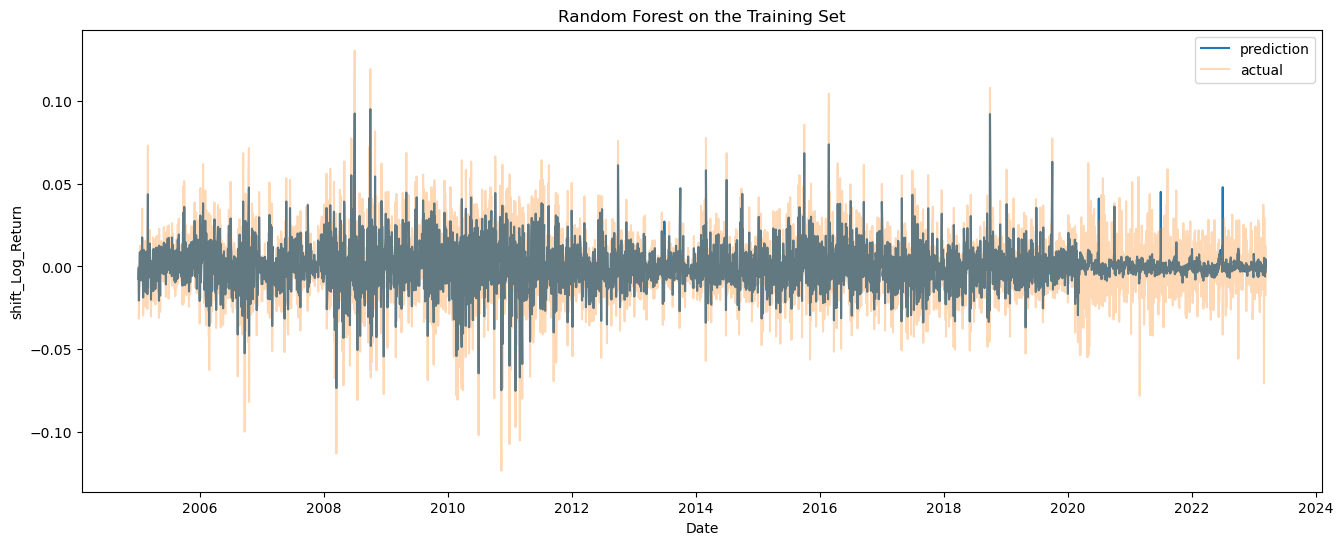

In [20]:
plt.figure(figsize=(16, 6))
plt.title('Random Forest on the Training Set')
sns.lineplot(x=X.index, y=rf_model.predict(X), label='prediction')
sns.lineplot(x=X.index, y=y, label='actual', alpha = 0.3)

#plt.figure(figsize=(16, 6))
#plt.title('The XGBoost Model on the testing set')
#sns.lineplot(x=ZW_test['Log Return'].index, y=y_pred, label='prediction')
#sns.lineplot(x=ZW_test['Log Return'].index, y=ZW_test['Log Return'], label='actual', alpha = 0.3)

In [21]:
# test on all the testing set
y = test_df['shift_Log_Return']
X = test_df.drop(columns=['shift_Log_Return'])
preds = rf_model.predict(X)
print(np.sqrt(mean_squared_error(preds,y)))
print(r2_score(preds,y))

0.019016023973816895
-12.737293050096419


In [ ]:
# test on a short time interval in the testing set
y = test_df['shift_Log_Return'].iloc[:2]
X = test_df.drop(columns=['shift_Log_Return']).iloc[:2]
preds = rf_model.predict(X)
print(np.sqrt(mean_squared_error(preds,y)))
print(r2_score(preds,y))

0.002908339633801775
-0.29512151408061316


<Axes: title={'center': 'Random Forest on the Testing Set'}, xlabel='Date', ylabel='shift_Log_Return'>

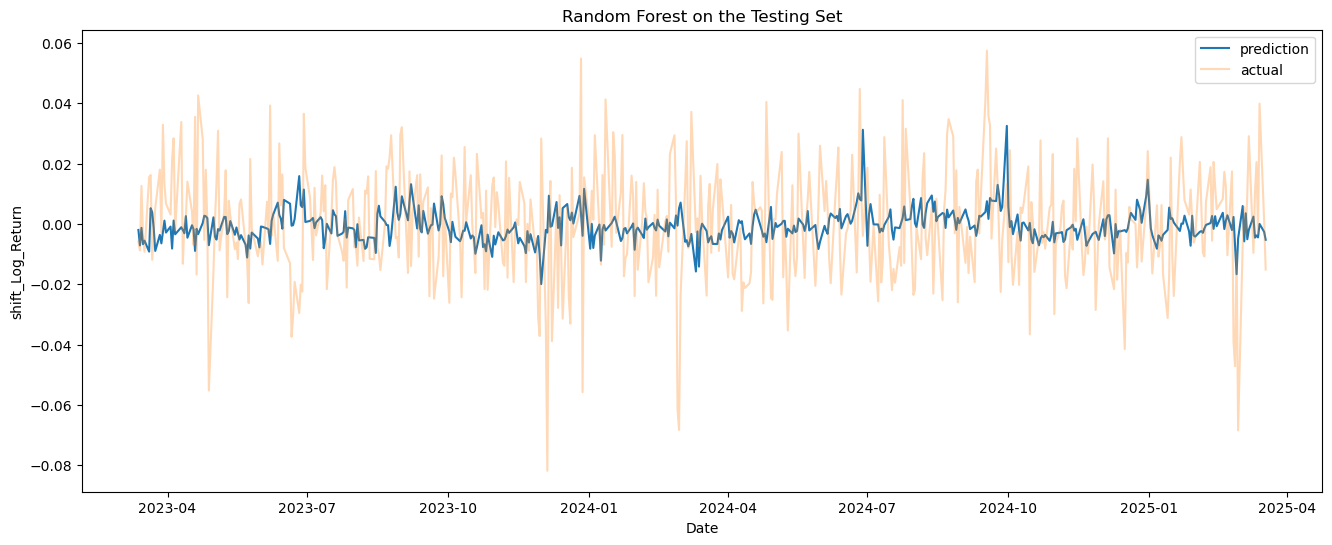

In [23]:
y = test_df['shift_Log_Return']
X = test_df.drop(columns=['shift_Log_Return'])
plt.figure(figsize=(16, 6))
plt.title('Random Forest on the Testing Set')
sns.lineplot(x=X.index, y=rf_model.predict(X), label='prediction')
sns.lineplot(x=X.index, y=y, label='actual', alpha = 0.3)